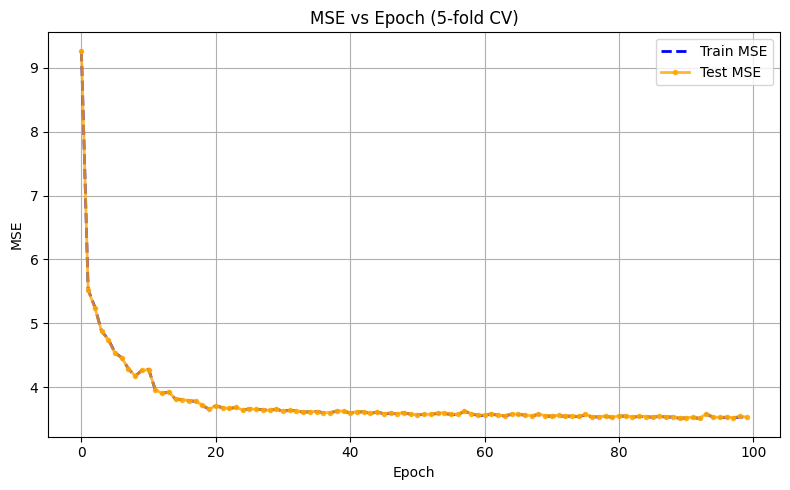


5-fold CV Results:
Train MSE:   3.5220 ± 0.0365
Test MSE:    3.5304 ± 0.0688
Train R2:    0.6275 ± 0.0037
Test R2:     0.6267 ± 0.0022
Train RMSLE: 0.1534 ± 0.0016
Test RMSLE:  0.1535 ± 0.0014


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import matplotlib.pyplot as plt

def manual_openfe_features(df_raw):
    df = df_raw.copy()
    eps = 0
    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)
    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)
    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / (df["Shell weight"] + eps),
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / (df["Shell weight"] + eps),
        "f03_Diameter_div_ShellWeight": df["Diameter"] / (df["Shell weight"] + eps),
        "f04_Whole_div_Whole1": df["Whole weight"] / (df["Whole weight.1"] + eps),
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f06_freq_ShellWeight": freq_feature_shell,
        "f07_freq_WholeWeight": freq_feature_whole
    })
    return df_manual


df = pd.read_csv("train_cleaned_sex_binary.csv")
y = df["Rings"].values
X_raw = df.drop(columns=["Rings", "id"], errors="ignore")
X_manual = manual_openfe_features(X_raw)
X_final = pd.concat([X_raw.reset_index(drop=True), X_manual], axis=1)
X_final = X_final.drop(columns=["Length", "Whole weight"], errors="ignore")
X_np = X_final.values


class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.model(x)


best_params = {
    'hidden_size': 61,
    'dropout_rate': 0.32695488002723083,
    'batch_size': 541,
    'lr': 0.0010097359056986408
}
n_epochs = 100
n_splits = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

train_mse_list, test_mse_list = [], []
train_r2_list, test_r2_list = [], []
train_rmsle_list, test_rmsle_list = [], []
mse_train_epoch_all, mse_test_epoch_all = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_np)):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True, num_workers=0)

    model = ANN(X_train.shape[1], best_params["hidden_size"], best_params["dropout_rate"]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
    criterion = nn.MSELoss()

    mse_train_epochs, mse_test_epochs = [], []

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_preds = model(X_train_tensor.to(device)).detach().cpu().numpy()
            test_preds = model(X_test_tensor.to(device)).detach().cpu().numpy()
            mse_train = mean_squared_error(y_train, train_preds)
            mse_test = mean_squared_error(y_test, test_preds)
            mse_train_epochs.append(mse_train)
            mse_test_epochs.append(mse_test)

    mse_train_epoch_all.append(mse_train_epochs)
    mse_test_epoch_all.append(mse_test_epochs)

    train_preds = model(X_train_tensor.to(device)).detach().cpu().numpy()
    test_preds = model(X_test_tensor.to(device)).detach().cpu().numpy()

    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    train_rmsle = np.sqrt(mean_squared_log_error(np.maximum(y_train, 0), np.maximum(train_preds, 0)))
    test_rmsle = np.sqrt(mean_squared_log_error(np.maximum(y_test, 0), np.maximum(test_preds, 0)))

    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)
    train_rmsle_list.append(train_rmsle)
    test_rmsle_list.append(test_rmsle)


avg_mse_train = np.mean(mse_train_epoch_all, axis=0)
avg_mse_test = np.mean(mse_test_epoch_all, axis=0)

plt.figure(figsize=(8, 5))
plt.plot(avg_mse_train, label='Train MSE', color='blue', linestyle='dashed', linewidth=2)
plt.plot(avg_mse_test, label='Test MSE', color='orange', linestyle='solid', linewidth=2, marker='o', markersize=3, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs Epoch (5-fold CV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("mse_vs_epoch.png")
plt.show()



print("\n5-fold CV Results:")
print(f"Train MSE:   {np.mean(train_mse_list):.4f} ± {np.std(train_mse_list):.4f}")
print(f"Test MSE:    {np.mean(test_mse_list):.4f} ± {np.std(test_mse_list):.4f}")
print(f"Train R2:    {np.mean(train_r2_list):.4f} ± {np.std(train_r2_list):.4f}")
print(f"Test R2:     {np.mean(test_r2_list):.4f} ± {np.std(test_r2_list):.4f}")
print(f"Train RMSLE: {np.mean(train_rmsle_list):.4f} ± {np.std(train_rmsle_list):.4f}")
print(f"Test RMSLE:  {np.mean(test_rmsle_list):.4f} ± {np.std(test_rmsle_list):.4f}")
